In [2]:
!pip install datasets
!pip install clean-text
!pip install transformers
!pip install sentencepiece
!pip install nlpaug
!pip install googletrans==3.1.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 26.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 7.9 MB/s eta 0:

In [3]:
import pandas as pd
from datasets import Dataset, DatasetDict
import matplotlib.pyplot as plt
import re
from cleantext import clean
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
import torch
from sklearn.metrics import f1_score
from transformers import Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import nlpaug.augmenter.word as naw
import googletrans
from googletrans import Translator
import numpy as np

# Dataset

In this part we read the dataset and we plot the distributions of the labels and the length of all the texts. 
We are dealing with a small dataset containing conspiratorial texts.

In [4]:
dataset = pd.read_csv("../datasets/subtaskB_train.csv")
dataset = dataset.drop('Id', axis=1)
dataset = dataset.drop('topic', axis=1)
dataset = dataset.rename(columns={'comment_text': 'text', 'conspiracy': 'label'})
dataset

,text,label
0,"Siamo davanti ad una prova, e non solo di quoz...",1
1,La storia dei 2 bimbi di Bergamo - vaccini: qu...,0
2,L'avete capito che non toglieranno il green pa...,0
3,Quindi la farsa dello spazio e della terra a ...,3
4,"In breve tempo, per accedere a Internet, sarà ...",1
...,...,...
805,"Incredibile!!!! EMA, Agenzia Europea del Farma...",0
806,Non ci saranno colloqui di pace con la Russia ...,2
807,"L'atmosfera è uno ""scudo protettivo"" che avvol...",3
808,OTTIMA NOTIZIA! Due ragioni per cui le élite n...,0


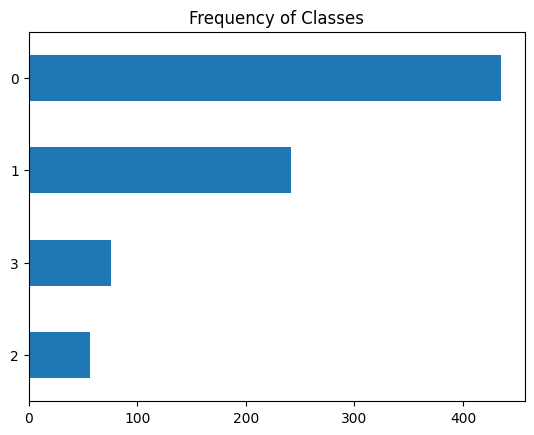

In [5]:
dataset['label'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

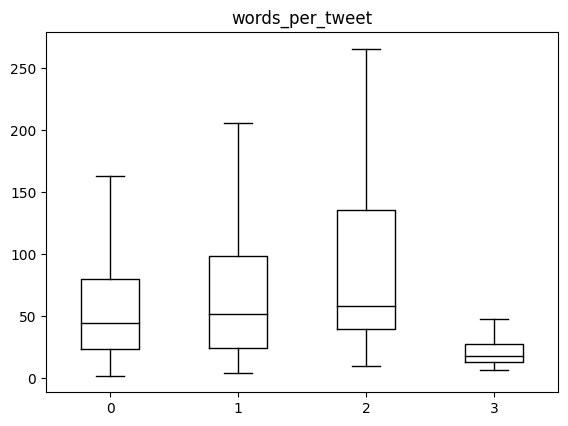

In [ ]:
dataset['words_per_tweet'] = dataset['text'].str.split().apply(len)
dataset.boxplot('words_per_tweet', by='label', grid=False, showfliers=False, color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

dataset = dataset.drop('words_per_tweet', axis=1)

# Text Cleaning

In this section, first of all, we define the function that we will use to clean our text. As we can se above there are some texts between parentesis that are usefull and also unicodes.
We are removing all that stuff creating a text that is similar to the ones used to train the pre-trained model. So, for instance, we won't remove the punctuation and and stopwords.

In [6]:
# We define the function for the cleaning of the text

def text_cleaning(text):
    # Convert words to lower case
    text = text.lower()
    text = clean(text, no_emoji=True)

    text = re.sub(r'(\[.*?\])', '', text)
    text = re.sub(r'[0-9]{2}\/[0-9]{2}\/[0-9]{2,4}', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'[_"\()|+&=*%#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\.+','.', text)
    text = re.sub(r'\,+',',', text)
    text = re.sub(r'\!+','!', text)
    text = re.sub(r'\?+','?', text)
    text = re.sub(r'\n+','', text)
    text = re.sub(r' +', ' ', text)
    text = re.sub('[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '', text)

    return text

In [7]:
dataset['text'] = list(map(text_cleaning, dataset.text))
dataset

,text,label
0,"siamo davanti ad una prova, e non solo di quoz...",1
1,la storia dei 2 bimbi di bergamo - vaccini: qu...,0
2,l'avete capito che non toglieranno il green pa...,0
3,quindi la farsa dello spazio e della terra a p...,3
4,"in breve tempo, per accedere a internet, sara ...",1
...,...,...
805,"incredibile! ema, agenzia europea del farmaco,...",0
806,non ci saranno colloqui di pace con la russia ...,2
807,l'atmosfera e uno scudo protettivo che avvolge...,3
808,ottima notizia! due ragioni per cui le elite n...,0


# Model download

In this part we are downloading the bert-model and it's tokenizer from the hugging face hub.
In that specific case we will use the bert multilingual model

In [8]:
model_name = 'bert-base-multilingual-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

In [10]:
# We controll if the device support the computation on the GPU, otherwise we will compute the model on the CPU
device = ('cuda' if torch.cuda.is_available() else 'cpu')

num_labels = 4  # Number of classes
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels).to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

## Metrics
We define the metric that we want to calculate during the fine-tuning of the model

In [11]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    return {'f1_score': f1}

In [12]:
from huggingface_hub import notebook_login
notebook_login()

In [13]:
def createDataset(train, val):
  tds = Dataset.from_pandas(train)
  vds = Dataset.from_pandas(val)
  dataset_hf = DatasetDict()
  
  dataset_hf['train'] = tds
  dataset_hf['validation'] = vds
  dataset_hf['train']= dataset_hf['train'].remove_columns("__index_level_0__")
  dataset_hf['validation']= dataset_hf['validation'].remove_columns("__index_level_0__")

  return dataset_hf

# Data Augmentation

In the following we will cope with the imbalacing problem of our dataset. So, the idea is to do a back translation of all the sentences that are not of the class 0 to increase the number of texts for each of them.
The result dataset is still imbalanced, but we have more data to train the model for the other classes.

First of all, usign the nlpaug library we will perform the back translation.

In [14]:
back_translation_aug = naw.BackTranslationAug(
    from_model_name='Helsinki-NLP/opus-mt-it-en',
    to_model_name='Helsinki-NLP/opus-mt-en-it', device='cuda', max_length=512)
estensione = back_translation_aug.augment(list(dataset.loc[dataset['label'] != 0]['text']))

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Then, we create the dataframe composed of new texts that we will add to the main one.

In [15]:
# function to translate text to another language and back to the original language
def back_translationGoogle(text):
    translator = Translator()
    translation = translator.translate(text, dest='fr').text
    translation = translator.translate(translation, dest='it').text
    return translation

extension = []
for text in dataset.loc[dataset['label'] > 1]['text']:
  extension.append(back_translationGoogle(text))

extension

["così la farsa dello spazio e della terra in mongolfiera continua con i suoi finti viaggi lunari e marziani. per il motivo che sono finanziati da miliardi di dollari. economicamente. mentre lanciano un razzo che è poi destinato a cadere nell'oceano. o atterrare in un'unica base. le persone poi ci cascano perché dopo aver visto il vero lancio, poi guardano un film realizzato nello stesso studio in cui producono i film Marvel. dove con la realtà virtuale possono fare quello che vogliono!",
 "se l'aspetto di questo pianeta influisce sul genio alieno che chiamiamo sole. e la luna. ovviamente sarà cavolo per tutti",
 'visto che hanno dovuto rifare la finta Antartide. farne un palo',
 'attenzione quindi a tutte le reazioni e risposte di aldrin che ovviamente difende la sua icona, ma in compenso si giustifica.',
 'attenzione che la nasa ha generalmente minimizzato e oscurato tutti i diversi avvisi come tutti i governi.',
 "c'è ancora chi crede che grazie ai satelliti ci sia il gps. falseoo 3

In [16]:
df_extension1 = pd.DataFrame(estensione, columns=['text'])
df_extension1['label'] = dataset.loc[dataset['label'] != 0]['label'].reset_index().drop('index', axis=1)
df_extension1

,text,label
0,"ci troviamo di fronte a una prova, e non solo ...",1
1,Così la farsa dello spazio e del calcio terra ...,3
2,In breve tempo sarà necessario un documento di...,1
3,se come questo pianeta sembra influenzare il c...,3
4,di Brian cates dall'incredibilmente accurata a...,1
...,...,...
370,"è chiaro, non è che la frode del mulo è l'unic...",1
371,Abraccia la terra spesso 2000 km oooh mi ricor...,3
372,Non ci saranno colloqui di pace con la Russia ...,2
373,L'atmosfera e uno scudo protettivo che circond...,3


In [17]:
df_extension2 = pd.DataFrame(extension, columns=['text'])
df_extension2['label'] = dataset.loc[dataset['label'] > 1]['label'].reset_index().drop('index', axis=1)
df_extension2

,text,label
0,così la farsa dello spazio e della terra in mo...,3
1,se l'aspetto di questo pianeta influisce sul g...,3
2,visto che hanno dovuto rifare la finta Antarti...,3
3,attenzione quindi a tutte le reazioni e rispos...,3
4,attenzione che la nasa ha generalmente minimiz...,3
...,...,...
128,povero zelenskya rete4 l'hanno fatto neroecco ...,2
129,avvolge la terra con uno spessore di 2000 km,3
130,Non ci saranno colloqui di pace con la Russia ...,2
131,l'atmosfera è uno scudo protettivo che circond...,3


Here we merge the extension with the main dataset

In [18]:
df_extended = pd.concat([dataset, df_extension1, df_extension2])
df_extended

,text,label
0,"siamo davanti ad una prova, e non solo di quoz...",1
1,la storia dei 2 bimbi di bergamo - vaccini: qu...,0
2,l'avete capito che non toglieranno il green pa...,0
3,quindi la farsa dello spazio e della terra a p...,3
4,"in breve tempo, per accedere a internet, sara ...",1
...,...,...
128,povero zelenskya rete4 l'hanno fatto neroecco ...,2
129,avvolge la terra con uno spessore di 2000 km,3
130,Non ci saranno colloqui di pace con la Russia ...,2
131,l'atmosfera è uno scudo protettivo che circond...,3


And as we can see below we have that the number of sentence for each of the imbalanced classes is doubled.

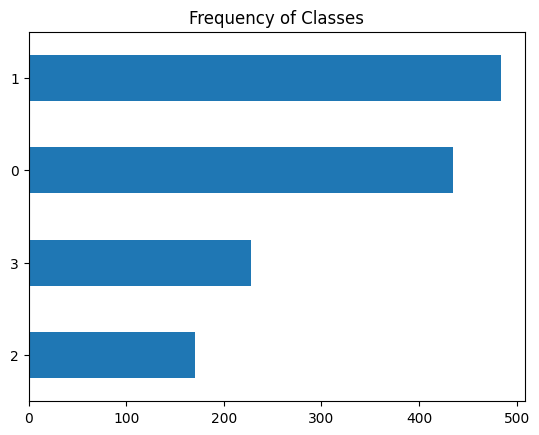

In [19]:
df_extended['label'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

## Cross-Validation

Now we will define the cross validation to find the best hyperparameters of the model. This since we have a very small dataset, so we are trying to generalize as much as possible.

In [ ]:
lr_rates = [2e-5, 3e-5]
epochs = [2,3,4]
lr_scheduler = ['constant']

log_results_cross = pd.DataFrame({
    'learning_rate': [],
    'epochs': [],
    'f1_score': [],
    'lr_scheduler': []
})

for lr in lr_rates:
  for epoch in epochs:
    for scheduler in lr_scheduler:
      results = []

      for i in range(5):
        # We create the split of the dataset, shuffling before the data
        train, val = train_test_split(df_extended, train_size=0.8, shuffle=True)
        df = createDataset(train, val)
        texts_encoded = df.map(tokenize, batched=True, batch_size=None)

        # We define the argument that the model has to use
        batch_size = 8
        logging_steps = len(texts_encoded['train'])
        model_name_hub = f'{model_name}-kcross'
        training_args = TrainingArguments(output_dir=model_name,
                                    num_train_epochs=epoch,
                                    learning_rate=lr,
                                    per_device_train_batch_size=batch_size,
                                    per_device_eval_batch_size=batch_size,
                                    weight_decay=0.01,
                                    evaluation_strategy='epoch',
                                    disable_tqdm=False,
                                    logging_steps=logging_steps,
                                    #lr_scheduler_type=scheduler,
                                    fp16=True,
                                    push_to_hub=False,
                                    log_level='error')
        # Train of the model
        trainer = Trainer(model=model,
                    args=training_args,
                    compute_metrics=compute_metrics,
                    train_dataset=texts_encoded['train'],
                    eval_dataset=texts_encoded['validation'],
                    tokenizer=tokenizer)
        trainer.train()
        results.append(trainer.predict(texts_encoded['validation']).metrics['test_f1_score'])
    
    # We calculate the mean of the f1_scores and we save the model and the result on a log
    mean_f1_score = sum(results) / len(results)
    print(mean_f1_score)

    # We log the actual parameters and the mean f1_score
    parameters = [lr, epoch, mean_f1_score, scheduler]
    log_results_cross.loc[len(log_results_cross)] = parameters
  
log_results_cross.to_csv('/log/log_cross_multi_new_aug_1.csv')

Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.536236,0.924382
2,No log,0.479865,0.927976


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.464338,0.943369
2,No log,0.420573,0.927875


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.568901,0.927743
2,No log,0.520537,0.927741


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.557472,0.916113
2,No log,0.856960,0.912541


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.036558,0.908293
2,No log,0.983646,0.919861


0.9231988330594657


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.797335,0.931627
2,No log,0.556003,0.943439
3,No log,0.608340,0.935470


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.562261,0.954435
2,No log,0.758649,0.943040
3,No log,0.758717,0.943040


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.746408,0.946830
2,No log,0.743653,0.946830
3,No log,0.757562,0.946830


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.757462,0.946830
2,No log,0.762083,0.946830
3,No log,0.773863,0.946830


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.776444,0.946830
2,No log,0.780178,0.946830
3,No log,0.786529,0.946830


0.9438000631283818


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.788687,0.946830
2,No log,0.792566,0.946830
3,No log,0.800877,0.946830
4,No log,0.829058,0.946846


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.836836,0.946846
2,No log,0.843890,0.946846
3,No log,1.297496,0.909416
4,No log,0.974788,0.939627


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.908501,0.939406
2,No log,0.913060,0.927995
3,No log,0.807293,0.950943
4,No log,0.984735,0.939627


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.978284,0.943394
2,No log,0.891044,0.935432
3,No log,0.696731,0.931226
4,No log,0.768238,0.939140


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.925340,0.931380
2,No log,1.451307,0.912392
3,No log,0.709006,0.923735
4,No log,0.560602,0.946781


0.9424040600432797


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.967276,0.935425
2,No log,0.775071,0.946792


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.932470,0.939191
2,No log,0.883643,0.943031


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.913177,0.943031
2,No log,0.938273,0.939208


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.949356,0.939208
2,No log,0.955873,0.939208


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.963564,0.939208
2,No log,0.968114,0.939208


0.9414891990433173


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.974817,0.939208
2,No log,0.983694,0.939208
3,No log,0.986646,0.939208


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.991906,0.939208
2,No log,0.997714,0.939208
3,No log,0.999527,0.939208


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.003647,0.939208
2,No log,1.007842,0.939208
3,No log,1.009189,0.939208


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.012451,0.939208
2,No log,1.016136,0.939208
3,No log,1.017319,0.939208


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.020345,0.939208
2,No log,1.023364,0.939208
3,No log,1.024488,0.939208


0.9392077142077142


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.026759,0.939208
2,No log,1.030451,0.939208
3,No log,1.031516,0.939208
4,No log,1.025515,0.943031


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.027378,0.943031
2,No log,1.030288,0.943031
3,No log,1.032108,0.943031
4,No log,1.032919,0.943031


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.034576,0.943031
2,No log,1.037197,0.943031
3,No log,1.038497,0.943031
4,No log,1.038942,0.943031


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.040788,0.943031
2,No log,1.042769,0.943031
3,No log,1.044299,0.943031
4,No log,1.044752,0.943031


Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,1.046061,0.943031
2,No log,1.047948,0.943031
3,No log,1.049080,0.943031
4,No log,1.049908,0.939208


0.9422665489863288


# Train final Model

Now that we finished the cross-validation, we take the best model found and we buil the final model.
Then, we push the model into the hugging face hub

In [20]:
train, val = train_test_split(df_extended, train_size=0.8, shuffle=True)
dataset_final_train = createDataset(train, val)
dataset_final_encoded = dataset_final_train.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/1054 [00:00<?, ? examples/s]

Map:   0%|          | 0/264 [00:00<?, ? examples/s]

In [22]:
# We take the best parameter from the log
idx_best_model = log_results_cross['f1_score'].idxmax()
learning_rate_best = log_results_cross['learning_rate'][idx_best_model]
epoch_best = float(log_results_cross['epochs'][idx_best_model])
#lr_scheduler_best = log_results_cross['lr_scheduler'][idx_best_model]

print(f'The learning rate of the best model is: {learning_rate_best}')
print(f'The number of epochs of the best model is: {epoch_best}')

# We define the arguments for the training 
batch_size = 8
logging_steps = len(dataset_final_encoded['train'])
model_name_hub = 'best-multilingual-multiCLS-5'

# We train the final model
training_args = TrainingArguments(output_dir=model_name_hub,
                                  num_train_epochs=epoch_best,
                                  learning_rate=learning_rate_best,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  #lr_scheduler_type=lr_scheduler_best,
                                  fp16=True,
                                  push_to_hub=True,
                                  log_level='error')

trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_final_encoded['train'],
                  eval_dataset=dataset_final_encoded['validation'],
                  tokenizer=tokenizer)
trainer.train()
trainer.push_to_hub()

The learning rate of the best model is: 2e-05
The number of epochs of the best model is: 3


/content/best-multilingual-multiCLS-5 is already a clone of https://huggingface.co/Mike00vito/best-multilingual-multiCLS-5. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,No log,0.591063,0.881987
2,No log,0.396699,0.923914
3,No log,0.381959,0.924079


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/638M [00:00<?, ?B/s]

Upload file runs/Apr29_19-58-12_58650037d11c/events.out.tfevents.1682798295.58650037d11c.408.2:   0%|         …

Upload file training_args.bin:   0%|          | 1.00/3.56k [00:00<?, ?B/s]

Upload file runs/Apr29_19-58-12_58650037d11c/1682798295.833393/events.out.tfevents.1682798295.58650037d11c.408…

To https://huggingface.co/Mike00vito/best-multilingual-multiCLS-5
   c51dcbb..cc0e478  main -> main

   c51dcbb..cc0e478  main -> main

To https://huggingface.co/Mike00vito/best-multilingual-multiCLS-5
   cc0e478..eb293bb  main -> main

   cc0e478..eb293bb  main -> main



'https://huggingface.co/Mike00vito/best-multilingual-multiCLS-5/commit/cc0e478011de6538e83541bf6e7064a854069d40'